In [209]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
tf.enable_eager_execution()


In [106]:
#data, info = tfds.load('mnist', with_info=True, data_dir='./data')
data, info = tfds.load('mnist', with_info=True, download=False, data_dir='./data')


In [112]:
train_data = tfds.as_numpy(data['train'])
test_data = tfds.as_numpy(data['test'])

In [113]:
X_train = []
y_train = []

for digit in train_data:
    X_train.append(digit['image'])
    y_train.append(digit['label'])       

X_train = np.array(X_train)
y_train = np.array(y_train)

In [114]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.15, random_state=0)

In [115]:
len(y_train)

51000

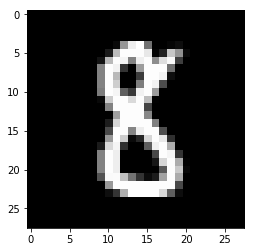

8


In [116]:
i = 10
plt.gray()
plt.imshow(X_train[i].reshape(28,28), interpolation='none')
plt.show()

print(y_train[i])


In [183]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(30, activation=tf.nn.relu),
  tf.keras.layers.Dense(30, activation=tf.nn.relu),
  tf.keras.layers.Dense(30, activation=tf.nn.relu),
  tf.keras.layers.Dense(30, activation=tf.nn.relu),
  tf.keras.layers.Dense(30, activation=tf.nn.relu),  
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [184]:
# https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#fit

output = model.fit(X_train, y_train, epochs=20,  validation_data=(X_validate, y_validate))

Train on 51000 samples, validate on 9000 samples
Epoch 1/20
51000/51000 [==============================] - 8s 155us/sample - loss: 0.8409 - acc: 0.8032 - val_loss: 0.3403 - val_acc: 0.9060
Epoch 2/20
51000/51000 [==============================] - 6s 120us/sample - loss: 0.2841 - acc: 0.9206 - val_loss: 0.2373 - val_acc: 0.9304
Epoch 3/20
51000/51000 [==============================] - 6s 126us/sample - loss: 0.2234 - acc: 0.9364 - val_loss: 0.2084 - val_acc: 0.9418
Epoch 4/20
51000/51000 [==============================] - 7s 129us/sample - loss: 0.1940 - acc: 0.9439 - val_loss: 0.1883 - val_acc: 0.9471
Epoch 5/20
51000/51000 [==============================] - 7s 137us/sample - loss: 0.1718 - acc: 0.9500 - val_loss: 0.2439 - val_acc: 0.9326
Epoch 6/20
51000/51000 [==============================] - 6s 119us/sample - loss: 0.1560 - acc: 0.9551 - val_loss: 0.1833 - val_acc: 0.9481
Epoch 7/20
51000/51000 [==============================] - 5s 108us/sample - loss: 0.1418 - acc: 0.9583 - val_lo

In [188]:
metrics = pd.DataFrame(output.history)

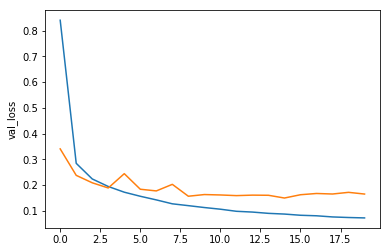

In [189]:
sns.lineplot(data=metrics, x = metrics.index, y='loss')
sns.lineplot(data=metrics, x = metrics.index, y='val_loss')